<a href="https://colab.research.google.com/github/sahupra1357/tensorflow/blob/main/Tensorflow_TransferLearning_FineTuning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
def unzip_helper(filename):
  # Unzip the downloaded file
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [2]:
if os.path.exists("101_food_classes_10_percent.zip"):
  print("the file exists")
else:
  !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

  unzip_helper("101_food_classes_10_percent.zip")

--2023-12-15 22:21:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.207, 64.233.187.207, 64.233.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  31.2MB/s    in 56s     

2023-12-15 22:22:15 (27.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [3]:
!ls

101_food_classes_10_percent  101_food_classes_10_percent.zip  __MACOSX	sample_data


In [4]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0

In [5]:
num_classes = 10
IMG_SIZE = 224
batchsize=32

In [6]:
train_directory_10 = '101_food_classes_10_percent/train'
test_directory_10 = '101_food_classes_10_percent/test'

In [7]:
train_data_10 = tf.keras.utils.image_dataset_from_directory(train_directory_10,label_mode='categorical',image_size=(IMG_SIZE,IMG_SIZE))
test_data_10 = tf.keras.utils.image_dataset_from_directory(test_directory_10,label_mode='categorical',image_size=(IMG_SIZE,IMG_SIZE), shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
data_agumentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2)
], name = 'data_agumentation')

In [9]:
class_names = train_data_10.class_names
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [10]:
num_classes = len(class_names)

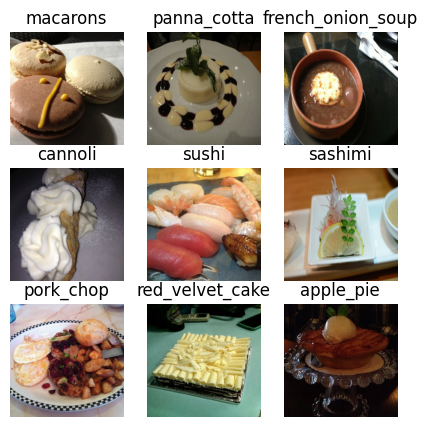

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_data_10.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.math.argmax(labels[i])])
    plt.axis("off")

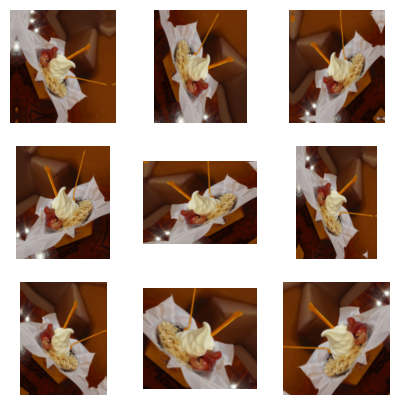

In [12]:
plt.figure(figsize=(5,5))
for images, _ in train_data_10.take(1):
  for i in range(9):
    augmented_images = data_agumentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
checkpoint_path = 'modelcheckpointpath/checkpoint.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                                         save_best_only=True,
                                                         monitor="val_accuracy",
                                                         verbose=1)

In [14]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [15]:
import matplotlib.pyplot as plt
def plot_graphs(model_history):
  loss = model_history['loss']
  val_loss = model_history['val_loss']

  accuracy = model_history['accuracy']
  val_accuracy = model_history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs,loss, label='Training loss')
  plt.plot(epochs,val_loss, label='Validation loss')
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs,accuracy, label='Training Accuracy')
  plt.plot(epochs,val_accuracy, label='Validation Accuracy')
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.legend()

In [16]:
import matplotlib.pyplot as plt
def plot_compare_graphs(original_history, new_history, initial_epochs=5):
  loss = original_history['loss']
  val_loss = original_history['val_loss']

  accuracy = original_history['accuracy']
  val_accuracy = original_history['val_accuracy']

  print(len(accuracy))

  toal_loss = loss + new_history['loss']
  toal_val_loss = val_loss + new_history['val_loss']

  toal_accuracy = accuracy + new_history['accuracy']
  toal_val_accuracy = val_accuracy + new_history['val_accuracy']

  print(len(toal_accuracy))

  plt.figure(figsize=(6, 6))
  plt.subplot(2, 1, 1)
  plt.plot(toal_accuracy, label='Training Accuracy')
  plt.plot(toal_val_accuracy, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(toal_loss, label='Training Loss')
  plt.plot(toal_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [17]:
def create_model_final(lr=0.001):
  base_model = EfficientNetV2B0(include_top=False)
  base_model.trainable = False

  inputs = tf.keras.Input((IMG_SIZE,IMG_SIZE,3))
  x = data_agumentation(inputs)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

  model = tf.keras.Model(inputs,outputs)
  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                metrics=['accuracy'])
  return model

In [18]:
model_1 = create_model_final()

24274472/24274472 [==============================] - 2s 0us/step


In [19]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_agumentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                             

In [20]:
history_all_classes_10_percent = model_1.fit(train_data_10,
                                           epochs=5,
                                           validation_data=test_data_10,
                                           validation_steps=int(0.15 * len(test_data_10)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.5332 - accuracy: 0.2337
Epoch 1: val_accuracy improved from -inf to 0.40572, saving model to modelcheckpointpath/checkpoint.ckpt
237/237 [==============================] - 213s 849ms/step - loss: 3.5332 - accuracy: 0.2337 - val_loss: 2.7012 - val_accuracy: 0.4057
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.4310 - accuracy: 0.4484
Epoch 2: val_accuracy improved from 0.40572 to 0.47405, saving model to modelcheckpointpath/checkpoint.ckpt
237/237 [==============================] - 138s 577ms/step - loss: 2.4310 - accuracy: 0.4484 - val_loss: 2.2342 - val_accuracy: 0.4740
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 2.0598 - accuracy: 0.5139
Epoch 3: val_accuracy improved from 0.47405 to 0.50874, saving model to modelcheckpointpath/checkpoint.ckpt
237/237 [==============================] - 110s 461ms/step - loss: 2.0598 - accuracy: 0.5139 - val_loss: 2.0208 - val_accura

In [21]:
# Evaluate model
results_feature_extraction_model = model_1.evaluate(test_data_10)
results_feature_extraction_model

790/790 [==============================] - 52s 66ms/step - loss: 1.6366 - accuracy: 0.5657


[1.6365758180618286, 0.565742552280426]

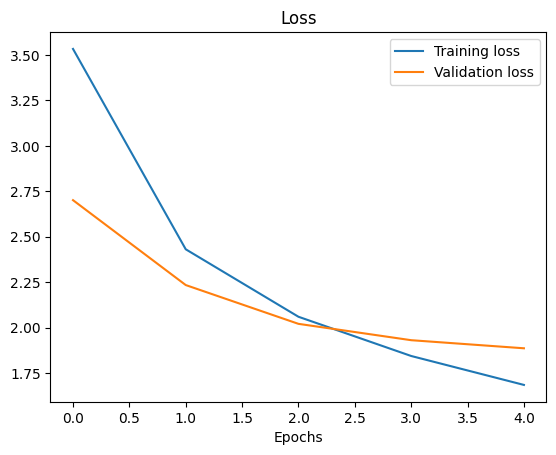

In [22]:
plot_graphs(history_all_classes_10_percent.history)

In [23]:
for layer_number, layer in enumerate(model_1.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 True
1 data_agumentation True
2 efficientnetv2-b0 False
3 global_average_pooling2d True
4 dense True


In [24]:
model_1_base_model = model_1.layers[2]
model_1_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_1_base_model.layers[:-5]:
  layer.trainable = False

In [25]:
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [26]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model_1.fit(train_data_10,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data_10,
                                                     validation_steps=int(0.15 * len(test_data_10)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 86s 327ms/step - loss: 1.4862 - accuracy: 0.6313 - val_loss: 1.7644 - val_accuracy: 0.5365
Epoch 6/10
237/237 [==============================] - 75s 312ms/step - loss: 1.3936 - accuracy: 0.6380 - val_loss: 1.7778 - val_accuracy: 0.5326
Epoch 7/10
237/237 [==============================] - 69s 289ms/step - loss: 1.3370 - accuracy: 0.6491 - val_loss: 1.7852 - val_accuracy: 0.5355
Epoch 8/10
237/237 [==============================] - 68s 284ms/step - loss: 1.2995 - accuracy: 0.6609 - val_loss: 1.7760 - val_accuracy: 0.5342
Epoch 9/10
237/237 [==============================] - 60s 251ms/step - loss: 1.2376 - accuracy: 0.6737 - val_loss: 1.7847 - val_accuracy: 0.5342
Epoch 10/10
237/237 [==============================] - 58s 243ms/step - loss: 1.2126 - accuracy: 0.6851 - val_loss: 1.7507 - val_accuracy: 0.5448


In [27]:
results_all_classes_10_percent_fine_tune = model_1.evaluate(test_data_10)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 57s 72ms/step - loss: 1.4701 - accuracy: 0.6051


[1.4700586795806885, 0.605108916759491]

5
11


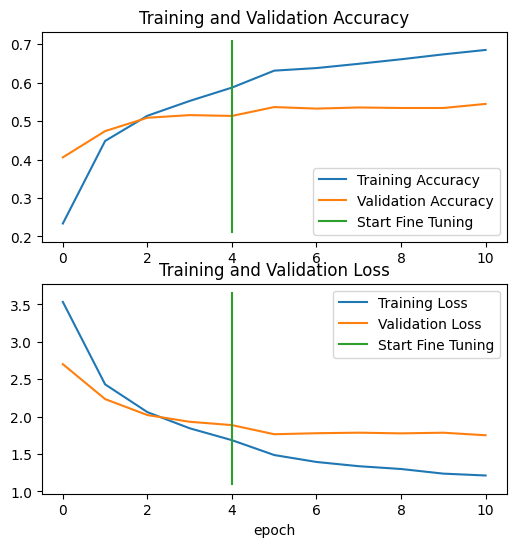

In [28]:
plot_compare_graphs(history_all_classes_10_percent.history,history_all_classes_10_percent_fine_tune.history)

In [29]:
pred_probs = model_1.predict(test_data_10, verbose=1) # set verbosity to see how long it will take

790/790 [==============================] - 58s 71ms/step


In [30]:
# How many predictions are there?
len(pred_probs)

25250

In [31]:
pred_probs.shape

(25250, 101)

In [32]:
pred_probs[:10]

array([[6.79630437e-04, 1.38237165e-05, 1.31480634e-01, ...,
        1.48644870e-06, 7.64328055e-04, 3.67627981e-05],
       [6.75062835e-01, 1.05270772e-07, 3.31542157e-02, ...,
        2.84329697e-04, 3.30688340e-06, 9.27498986e-05],
       [3.76993328e-01, 1.95269648e-04, 1.72055308e-02, ...,
        1.70787459e-03, 1.30109710e-03, 2.57508783e-03],
       ...,
       [2.88757712e-01, 1.11961594e-06, 3.77768688e-02, ...,
        2.50036654e-04, 2.52982107e-04, 3.05073743e-04],
       [7.40023926e-02, 4.38980751e-05, 9.78224277e-02, ...,
        3.77907557e-03, 2.00757073e-04, 5.41630900e-04],
       [3.69894594e-01, 3.09788192e-07, 7.23202713e-03, ...,
        3.43831512e-03, 1.67086164e-05, 4.39455471e-04]], dtype=float32)

In [33]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [6.79630437e-04 1.38237165e-05 1.31480634e-01 5.88465923e-07
 3.42125568e-05 8.03726434e-05 1.99754886e-05 1.32928562e-05
 2.75055208e-04 3.54712713e-04 6.71877069e-06 2.23123134e-05
 4.88404730e-05 1.18827429e-05 5.32219047e-03 1.85125209e-02
 9.10484756e-04 8.13378545e-04 2.67733750e-03 6.23663946e-04
 1.07953162e-03 6.36432969e-06 4.22439662e-05 4.40422991e-05
 7.69923499e-05 1.01537642e-03 8.53555510e-04 6.31971852e-06
 9.05735884e-03 3.12512202e-05 2.17135516e-06 8.69846335e-05
 1.26597215e-03 4.22285775e-05 1.98253477e-03 2.60864836e-05
 1.49878673e-03 1.10335427e-03 5.88002615e-03 1.21253215e-04
 1.83362199e-03 2.53229693e-04 1.50125297e-05 9.48774832e-05
 4.01114885e-05 3.34292999e-05 4.46485152e-04 1.11917390e-04
 2.36467367e-05 1.80474725e-02 1.55405991e-03 4.90020670e-04
 5.01424707e-02 1.74772032e-02 4.35203674e-06 3.88211280e-04
 1.59756502e-03 6.25155633e-04 9.70040041e-

In [34]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([85,  0,  0,  0,  8, 78, 29, 46,  9, 41])

In [35]:
y_labels = []
for images, labels in test_data_10.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [37]:
len(y_labels)

25250

In [38]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6051089108910891

In [40]:
results_all_classes_10_percent_fine_tune[1]

0.605108916759491

In [41]:
import numpy as np
print(f"Close? {np.isclose(results_all_classes_10_percent_fine_tune[1], sklearn_accuracy)} | Difference: {results_all_classes_10_percent_fine_tune[1] - sklearn_accuracy}")

Close? True | Difference: 5.86840187555282e-09


In [42]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [43]:
class_names = test_data_10.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [44]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.37      0.13      0.19       250
           1       0.70      0.64      0.67       250
           2       0.71      0.53      0.61       250
           3       0.72      0.58      0.65       250
           4       0.53      0.38      0.44       250
           5       0.59      0.34      0.43       250
           6       0.74      0.80      0.77       250
           7       0.83      0.71      0.77       250
           8       0.33      0.54      0.41       250
           9       0.35      0.74      0.47       250
          10       0.50      0.47      0.49       250
          11       0.61      0.62      0.61       250
          12       0.74      0.62      0.67       250
          13       0.59      0.57      0.58       250
          14       0.58      0.54      0.56       250
          15       0.37      0.31      0.34       250
          16       0.64      0.56      0.60       250
          17       0.43    

In [46]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3707865168539326,
  'recall': 0.132,
  'f1-score': 0.19469026548672566,
  'support': 250},
 '1': {'precision': 0.7048458149779736,
  'recall': 0.64,
  'f1-score': 0.6708595387840671,
  'support': 250},
 '2': {'precision': 0.7096774193548387,
  'recall': 0.528,
  'f1-score': 0.6055045871559633,
  'support': 250},
 '3': {'precision': 0.7227722772277227,
  'recall': 0.584,
  'f1-score': 0.6460176991150444,
  'support': 250},
 '4': {'precision': 0.5277777777777778,
  'recall': 0.38,
  'f1-score': 0.4418604651162791,
  'support': 250},
 '5': {'precision': 0.589041095890411,
  'recall': 0.344,
  'f1-score': 0.4343434343434343,
  'support': 250},
 '6': {'precision': 0.7397769516728625,
  'recall': 0.796,
  'f1-score': 0.7668593448940271,
  'support': 250},
 '7': {'precision': 0.8317757009345794,
  'recall': 0.712,
  'f1-score': 0.7672413793103448,
  'support': 250},
 '8': {'precision': 0.32926829268292684,
  'recall': 0.54,
  'f1-score': 0.40909090909090906,
  'support':

In [47]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.19469026548672566,
 'baby_back_ribs': 0.6708595387840671,
 'baklava': 0.6055045871559633,
 'beef_carpaccio': 0.6460176991150444,
 'beef_tartare': 0.4418604651162791,
 'beet_salad': 0.4343434343434343,
 'beignets': 0.7668593448940271,
 'bibimbap': 0.7672413793103448,
 'bread_pudding': 0.40909090909090906,
 'breakfast_burrito': 0.470737913486005,
 'bruschetta': 0.4854771784232365,
 'caesar_salad': 0.6123260437375745,
 'cannoli': 0.6739606126914661,
 'caprese_salad': 0.5795918367346938,
 'carrot_cake': 0.5619834710743802,
 'ceviche': 0.3355119825708061,
 'cheese_plate': 0.5974576271186439,
 'cheesecake': 0.44054580896686163,
 'chicken_curry': 0.434108527131783,
 'chicken_quesadilla': 0.5727699530516431,
 'chicken_wings': 0.726530612244898,
 'chocolate_cake': 0.58984375,
 'chocolate_mousse': 0.4225941422594142,
 'churros': 0.7245119305856834,
 'clam_chowder': 0.7386609071274299,
 'club_sandwich': 0.641732283464567,
 'crab_cakes': 0.42472266244057055,
 'creme_brulee': 0.7193

In [48]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33    edamame  0.960938
75        pho  0.866530
63   macarons  0.865342
69    oysters  0.853061
32  dumplings  0.840237

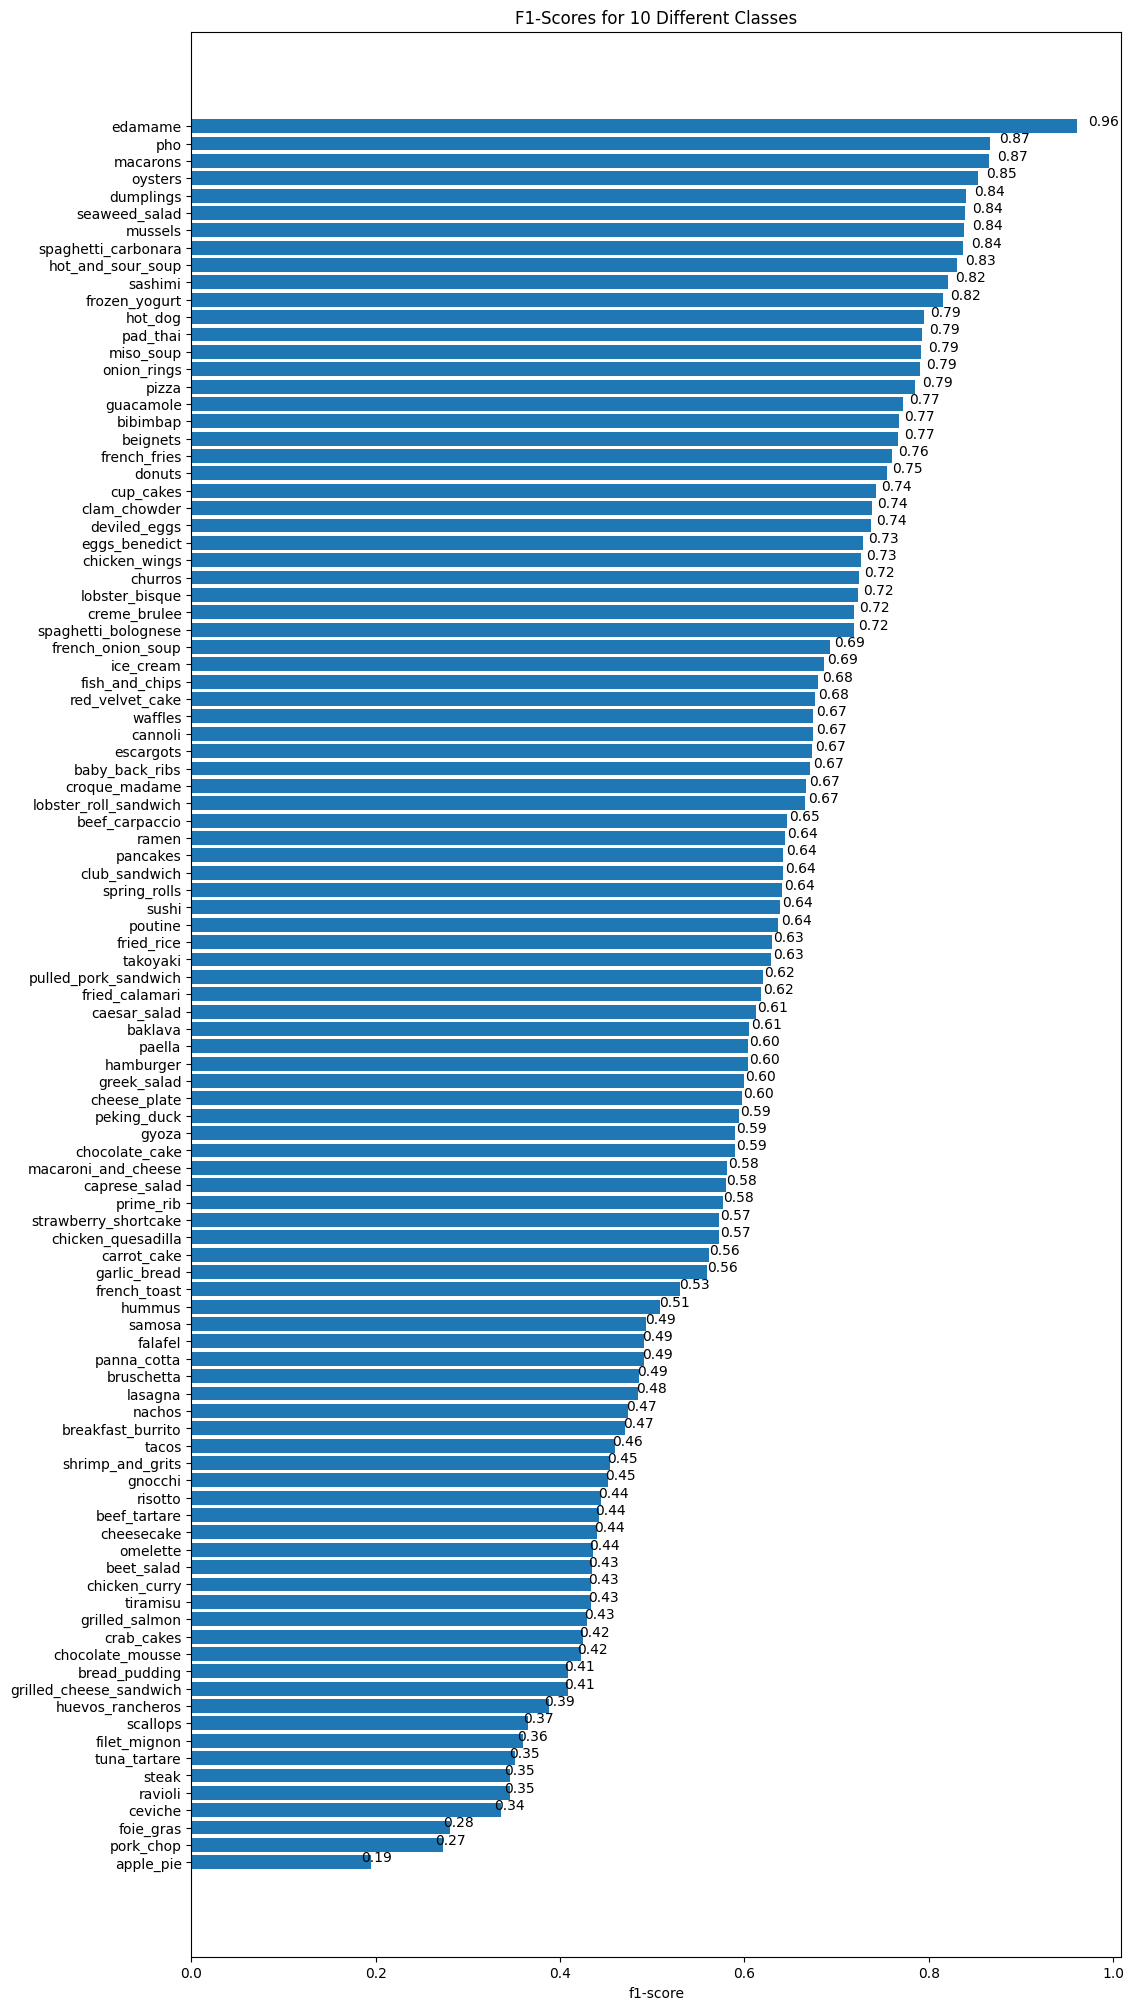

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [52]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

101_food_classes_10_percent/test/grilled_cheese_sandwich/2520949.jpg
1/1 [==============================] - 3s 3s/step
101_food_classes_10_percent/test/beef_carpaccio/2043824.jpg
1/1 [==============================] - 0s 28ms/step
101_food_classes_10_percent/test/lasagna/2960596.jpg
1/1 [==============================] - 0s 31ms/step


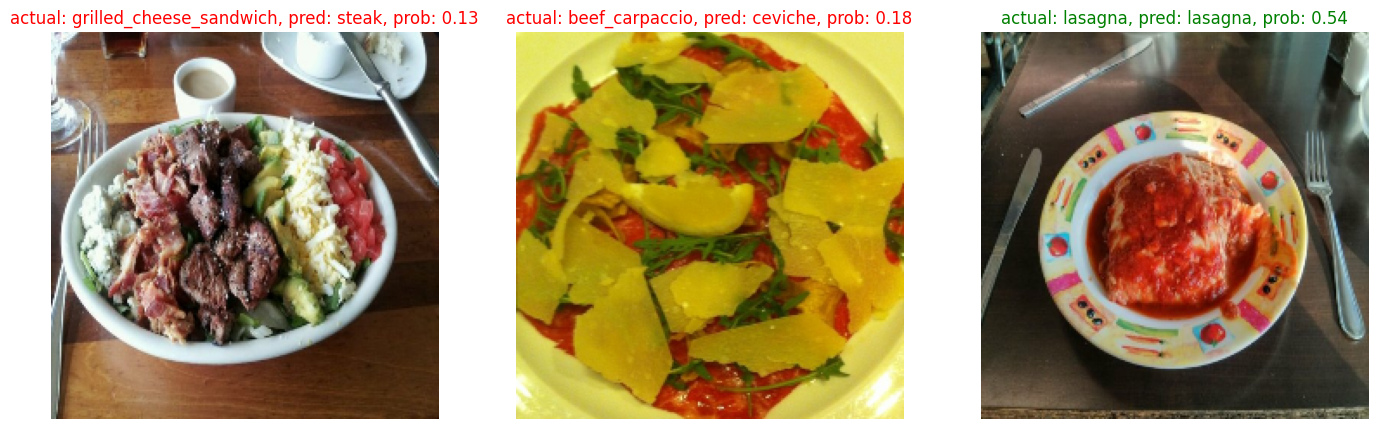

In [54]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_directory_10 + "/" + class_name))
  filepath = test_directory_10  + "/" + class_name + "/" + filename
  print(filepath)
  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [55]:
filepaths = []
for filepath in test_data_10.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [56]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      85   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.621090        apple_pie           samosa  
1   0.675063        apple_pie        apple_pie  
2   0.376993        apple_pie        apple_pie  
3   0.251995        apple_pie        apple_pie  
4   0.797652        apple_pie    bread_pudding

In [57]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      85   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.621090        apple_pie           samosa         False  
1   0.675063        apple_pie        apple_pie          True  
2   0.376993        apple_pie        apple_pie          True  
3   0.251995        apple_pie        apple_pie          True  
4   0.797652        apple_pie    bread_pudding         False

In [58]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
14482  b'101_food_classes_10_percent/test/hummus/8476...      57      51   
9402   b'101_food_classes_10_percent/test/filet_migno...      37      79   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   
4836   b'101_food_classes_10_percent/test/chicken_que...      19       9   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
18541  b'101_food_classes_10_percent/test/peking_duck...      74      85   
8612   b'101_food_classes_10_percent/test/eggs_benedi...      34      53   
9690   b'101_food_classes_10_percent/test/fish_and_ch...      38      20   
9227   b'101_food_classes_10_percent/test/falafel/676...      36      26   
18678  b'101_food_classes_10_percent/test/peking_duck...      74      79   
722    b'101_food_classes_10_percent/test/baklava/640...       2      85   
17897  b'101_food_classes_10_percent/test/paella/2986...      71      65   
20191  b'101_food_classes_10_percent/test/pulled_pork...      80       9   
11697  b'101_food_classes_10_percent/test/garlic_brea...      46      35   
9090   b'101_food_classes_10_percent/test/falafel/221...      36      51   
17908  b'101_food_classes_10_percent/test/paella/3192...      71      65   
9223   b'101_food_classes_10_percent/test/falafel/612...      36      26   
5114   b'101_food_classes_10_percent/test/chicken_win...      20      38   
22044  b'101_food_classes_10_percent/test/seaweed_sal...      88       5   
4851   b'101_food_classes_10_percent/test/chicken_que...      19      51   

       pred_conf      y_true_classname   y_pred_classname  pred_correct  
14482   0.998660                hummus          guacamole         False  
9402    0.997729          filet_mignon          prime_rib         False  
10880   0.996718        fried_calamari        onion_rings         False  
4836    0.995759    chicken_quesadilla  breakfast_burrito         False  
18001   0.995470              pancakes           omelette         False  
18541   0.995005           peking_duck             samosa         False  
8612    0.991620         eggs_benedict          hamburger         False  
9690    0.990663        fish_and_chips      chicken_wings         False  
9227    0.990063               falafel         crab_cakes         False  
18678   0.989748           peking_duck          prime_rib         False  
722     0.989722               baklava             samosa         False  
17897   0.989041                paella            mussels         False  
20191   0.988152  pulled_pork_sandwich  breakfast_burrito         False  
11697   0.986098          garlic_bread          escargots         False  
9090    0.985403               falafel          guacamole         False  
17908   0.985020                paella            mussels         False  
9223    0.984638               falafel         crab_cakes         False  
5114    0.984614         chicken_wings     fish_and_chips         False  
22044   0.984353         seaweed_salad         beet_salad         False  
4851    0.983567    chicken_quesadilla          guacamole         False

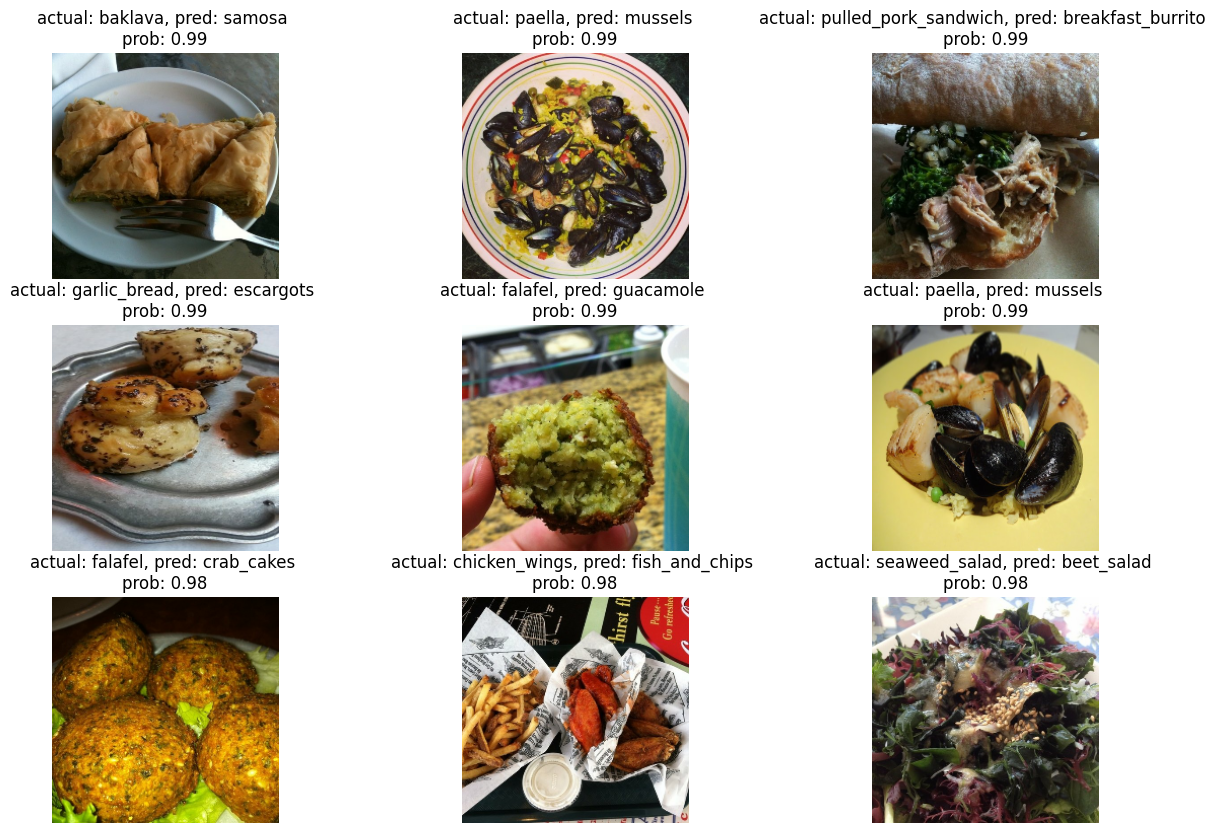

In [59]:
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

In [60]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_helper("custom_food_images.zip")

--2023-12-15 23:02:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.207, 142.251.170.207, 173.194.174.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  9.64MB/s    in 1.3s    

2023-12-15 23:02:47 (9.64 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [61]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg']

1/1 [==============================] - 0s 50ms/step


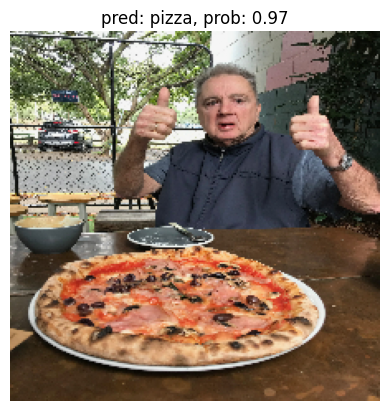

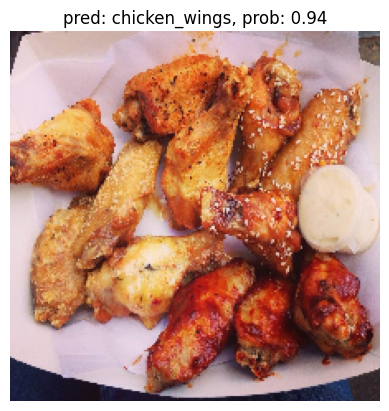

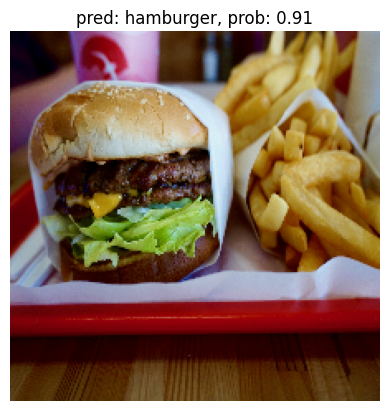

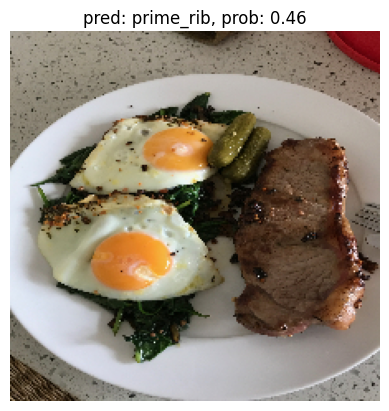

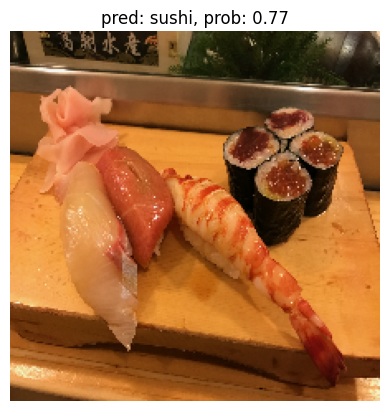

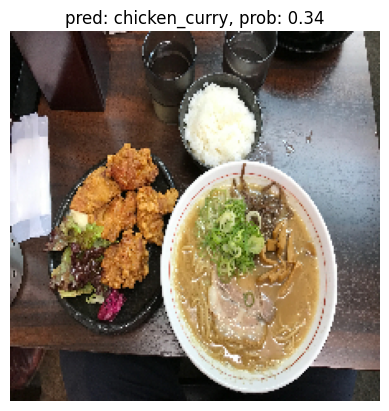

In [63]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)